In [1]:
import pandas as pd
import numpy as np 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import json

from collections import defaultdict
from tqdm import tqdm

from pathlib import Path
from typing import List, Dict, Tuple, Union, Callable, Optional, Any

In [2]:
surrogate_analysis_folder = "../analysis/surrogates/30_runs"
raw_mo_analysis_folder = "../analysis/raw_mo/4000"
seed_list = list(range(10,310,10))

In [3]:
def gather_surrogate_results(surrogate_analysis_folder: str, seed_list: List[int]) -> Dict[int, Dict[int, Dict[int, Dict[str, Any]]]]:
    """
    Gathers the results of the surrogate analysis.
    """
    size_seed_results = defaultdict(lambda: defaultdict(dict))
    for pareto_steps in os.listdir(surrogate_analysis_folder):
        pareto_steps_folder = os.path.join(surrogate_analysis_folder, pareto_steps)
        for data_size in os.listdir(pareto_steps_folder):
            for seed in seed_list: 
                seed_folder = os.path.join(pareto_steps_folder, data_size, str(seed))
                with open(os.path.join(seed_folder, "pareto_metrics.json"), "r") as f:
                    results = json.load(f)
                size_seed_results[int(pareto_steps)][int(data_size)][seed] = results
                
    return size_seed_results
    

In [4]:
def gather_raw_mo_results(raw_mo_analysis_folder: str, seed_list: List[int]) -> Dict[int, Dict[int, Dict[int, Dict[str, Any]]]]:
    """
    Gathers the results of the raw_mo analysis.
    """
    size_seed_results = defaultdict(lambda: defaultdict(dict))
    for pareto_steps in os.listdir(raw_mo_analysis_folder):
        pareto_steps_folder = os.path.join(raw_mo_analysis_folder, pareto_steps)
        for seed in seed_list: 
            seed_folder = os.path.join(pareto_steps_folder, str(seed))
            with open(os.path.join(seed_folder, "pareto_metrics.json"), "r") as f:
                results = json.load(f)
            size_seed_results[int(pareto_steps)][seed] = results
                
    return size_seed_results
    

In [5]:
def get_avg_results(size_seed_results: Dict, metric: str, pareto_steps: int) -> Dict[int, Dict[int, Dict[int, Dict[str, Any]]]]:
    """
    Returns the average results for a given metric.
    """

    avg_results = {}
    for data_size in size_seed_results[pareto_steps].keys():
        avg_results[data_size] = np.mean([size_seed_results[pareto_steps][data_size][seed][metric] for seed in seed_list])
        
    
    return avg_results


def get_avg_raw_mo_results(size_seed_results: Dict, metric: str, pareto_steps: int, seed_list: List[int]) -> int:
    """
    Returns the average results for a given metric.
    """

    #avg_results = {}
    avg_results = np.mean([size_seed_results[pareto_steps][seed][metric] for seed in seed_list])
        
    
    return avg_results

In [6]:
def get_total_trained_archs(size_seed_results: Dict, pareto_steps: int, seed_list: List[int]) -> Dict[int, Dict[int, Dict[int, Dict[str, Any]]]]:
    """
    Returns the total number of trained architectures for each data size.
    """
    total_trained_archs = defaultdict(lambda: defaultdict(int))

    for data_size in size_seed_results[pareto_steps].keys():
        for seed in seed_list: 
            total_trained_archs[data_size][seed] += size_seed_results[pareto_steps][data_size][seed]["trained_arch_cnt"]
            
    return total_trained_archs
    
    
def get_avg_trained_archs_per_step(total_trained_archs: Dict, step: int) -> Dict:
    
    avg_trained_archs_per_step = {}
    for data_size in total_trained_archs.keys():
        avg_trained_archs_per_step[data_size] = np.mean([total_trained_archs[data_size][seed] for seed in seed_list])
        
    avg_trained_archs_per_step = {k: v/step for k, v in avg_trained_archs_per_step.items()}         
        
    return avg_trained_archs_per_step
    

#### Results dict example: 
```
{
    'trained_arch_cnt': 3399,
    'hypervolume': 52.56181391334056,
    'avg_hypervolume': 4.778346719394596,
    'diameter': 18,
    'podist_avg': 6.363636363636363,
    'best_acc': 0.9466145634651184,
    'best_train_time': 546.0150146484375,
    'avg_acc': 0.9250528053803877,
    'avg_train_time': 1297.5351895419035,
    'std_acc': 0.030014588105400416,
    'std_train_time': 529.5832355037414
}
```

## The analysis for 20 pareto steps

In [26]:
size_seed_results_20 = gather_surrogate_results(surrogate_analysis_folder, seed_list)
total_trained_archs_20 = get_total_trained_archs(size_seed_results_20, 20, seed_list)
hypervolume_20 = get_avg_results(size_seed_results_20, "hypervolume", 20)
diameter_20 = get_avg_results(size_seed_results_20, "diameter", 20)
best_acc_20 = get_avg_results(size_seed_results_20, "best_acc", 20)
best_train_time_20 = get_avg_results(size_seed_results_20, "best_train_time", 20)

In [27]:
avg_train_per_run = {}
for data_size in total_trained_archs_20: 
    avg_train_per_run[data_size] = np.mean([total_trained_archs_20[data_size][seed] for seed in seed_list])
    
np.mean([avg_train_per_run[train_size] for train_size in avg_train_per_run])

4486.436363636364

In [28]:
avg_train_per_run

{800: 4294.8,
 500: 4201.6,
 3000: 5065.8,
 700: 4043.6,
 400: 4863.4,
 2000: 4252.8,
 300: 4323.4,
 1000: 4252.8,
 5000: 4307.2,
 900: 4783.0,
 600: 4962.4}

In [29]:
trained_archs_per_step = get_avg_trained_archs_per_step(total_trained_archs_20, 20)
total_step_avg = np.mean(([val for val in trained_archs_per_step.values()]))
total_step_avg

224.32181818181817

### Since we have `4487` architectures trained for 20 steps for 20 stating points and we have trained the surrogate models up to 1000 data size and the average step trains around 225 architectures, we can add 5 more steps to MO.

Gathering the RAW MO data here.

In [11]:
raw_mo_seed_list = list(range(1,300,10))

In [12]:
raw_size_seed_results = gather_raw_mo_results(raw_mo_analysis_folder, raw_mo_seed_list)


In [15]:
raw_size_seed_results.keys()

dict_keys([21, 24, 23, 22, 25, 20])

Below I am putting the results for all RAW MO steps and I will plot them with the surrogate models.

In [18]:
raw_size_seed_results[20].keys()

dict_keys([1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101, 111, 121, 131, 141, 151, 161, 171, 181, 191, 201, 211, 221, 231, 241, 251, 261, 271, 281, 291])

In [20]:
raw_diameters  = {}
raw_hypervolumes = {}
raw_best_accs = {}
raw_best_train_times = {}

for pareto_steps in raw_size_seed_results.keys():
    raw_diameters[pareto_steps] = get_avg_raw_mo_results(raw_size_seed_results, "diameter", pareto_steps, raw_mo_seed_list)
    raw_hypervolumes[pareto_steps] = get_avg_raw_mo_results(raw_size_seed_results, "hypervolume", pareto_steps, raw_mo_seed_list)
    raw_best_accs[pareto_steps] = get_avg_raw_mo_results(raw_size_seed_results, "best_acc", pareto_steps, raw_mo_seed_list)
    raw_best_train_times[pareto_steps] = get_avg_raw_mo_results(raw_size_seed_results, "best_train_time", pareto_steps, raw_mo_seed_list)

In [21]:
for pareto_steps in size_seed_results_20.keys(): 
    for data_size in size_seed_results_20[pareto_steps].keys(): 
        for seed in size_seed_results_20[pareto_steps][data_size].keys(): 
            print(size_seed_results_20[pareto_steps][data_size][seed]["best_acc"])

0.9466145634651184
0.9445112347602844
0.9461137652397156
0.9401041865348816
0.9443109035491943
0.9422075152397156
0.9447115659713745
0.9471153616905212
0.9459134340286255
0.9449118375778198
0.9438101053237915
0.9425080418586731
0.9436097741127014
0.9417067170143127
0.9451121687889099
0.9426081776618958
0.9473156929016113
0.9438101053237915
0.9434094429016113
0.9461137652397156
0.9428085088729858
0.9475160241127014
0.9497195482254028
0.9436097741127014
0.9442107081413269
0.9438101053237915
0.94140625
0.9425080418586731
0.9436097741127014
0.9434094429016113
0.9436097741127014
0.9450120329856873
0.9424078464508057
0.9459134340286255
0.9459134340286255
0.9467147588729858
0.9443109035491943
0.9452123641967773
0.9419070482254028
0.9485176205635071
0.9460136294364929
0.9460136294364929
0.9439102411270142
0.9436097741127014
0.9416065812110901
0.948317289352417
0.9451121687889099
0.9440104365348816
0.9452123641967773
0.9447115659713745
0.9451121687889099
0.9451121687889099
0.9485176205635071
0.

In [14]:
for pareto_steps in raw_size_seed_results.keys():
    for seed in raw_size_seed_results[pareto_steps].keys():
        print(raw_size_seed_results[pareto_steps][seed]["best_acc"])  

0.9471153616905212
0.9465144276618958
0.9473156929016113
0.9486178159713745
0.9473156929016113
0.9472155570983887
0.9471153616905212
0.9465144276618958
0.9473156929016113
0.9486178159713745
0.9473156929016113
0.9472155570983887
0.9471153616905212
0.9465144276618958
0.9473156929016113
0.9486178159713745
0.9473156929016113
0.9472155570983887
0.9471153616905212
0.9465144276618958
0.9473156929016113
0.9486178159713745
0.9473156929016113
0.9472155570983887
0.9471153616905212
0.9465144276618958
0.9473156929016113
0.9486178159713745
0.9473156929016113
0.9472155570983887
0.9471153616905212
0.9465144276618958
0.9473156929016113
0.9486178159713745
0.9473156929016113
0.9472155570983887


In [23]:
def plot_results(results: Dict, title: str, x_label: str, y_label: str, sizes: List[int], rotation: int = 45) -> None:
    """
    Plots the results.
    """
    selected_data = {key: results[key] for key in sizes}

    
    plt.figure(figsize=(10, 6))
    plt.plot(selected_data.keys(), selected_data.values(), marker='o')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=rotation)
    
    plt.show()


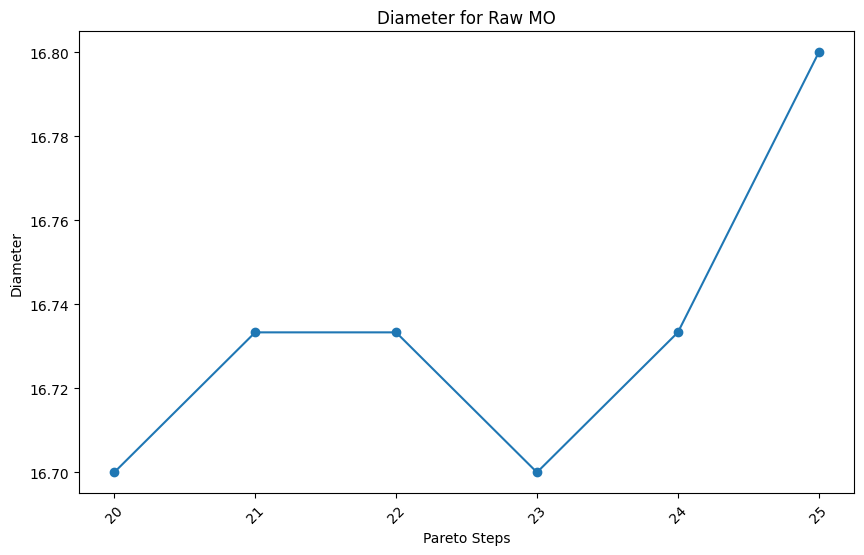

In [24]:
plot_results(raw_diameters, title="Diameter for Raw MO", x_label="Pareto Steps", y_label="Diameter", sizes=[20,21,22,23,24,25])

### I will compare the Raw MO results with the Data Centric NAS results.

I am mapping the trained architecture counts to number of average pareto steps.

In [31]:
avg_raw_trained_archs = {}
for pareto_steps in raw_size_seed_results.keys():
    avg_raw_trained_archs[pareto_steps] = np.mean([raw_size_seed_results[pareto_steps][seed]["trained_arch_cnt"] for seed in raw_mo_seed_list])
    
avg_raw_trained_archs

{21: 4795.566666666667,
 24: 5390.4,
 23: 5196.9,
 22: 4993.333333333333,
 25: 5599.066666666667,
 20: 4596.166666666667}

In [32]:
avg_train_per_run_combined = {data_size: data_size+avg_train_per_run[data_size] for data_size in avg_train_per_run}
avg_train_per_run_combined

{800: 5094.8,
 500: 4701.6,
 3000: 8065.8,
 700: 4743.6,
 400: 5263.4,
 2000: 6252.8,
 300: 4623.4,
 1000: 5252.8,
 5000: 9307.2,
 900: 5683.0,
 600: 5562.4}

In [33]:
selected_raw_mo_data = {key: avg_raw_trained_archs[key] for key in [20,21,22,23,24,25]}
selected_surr_mo_data = {key: avg_train_per_run_combined[key] for key in [300,400,500,600,700,800,900,1000]}

In [34]:
hypervolume_20

{800: 47.91386622882161,
 500: 49.262247890109265,
 3000: 47.183688405257854,
 700: 48.35969935739881,
 400: 43.67844605150065,
 2000: 37.914442740687875,
 300: 51.87518343594655,
 1000: 52.795665407091064,
 5000: 48.73523138269057,
 900: 55.63137151467381,
 600: 55.371384746664305}

In [46]:
raw_diameters

{21: 17.6, 24: 17.2, 23: 17.2, 22: 17.6, 25: 17.2, 20: 17.6}

In [35]:
surr_plot_data = {selected_surr_mo_data[key]: hypervolume_20[key] for key in [300,400,500,600,700,800,900,1000]}
raw_mo_plot_data = {selected_raw_mo_data[key]: raw_hypervolumes[key] for key in [20,21,22,23,24,25]}

In [36]:
raw_mo_plot_data

{4596.166666666667: 51.11687933556752,
 4795.566666666667: 51.53597879744098,
 4993.333333333333: 51.750593734183575,
 5196.9: 51.459355018766054,
 5390.4: 51.762286402036466,
 5599.066666666667: 51.38278797484932}

In [37]:
dict(sorted(surr_plot_data.items()))

{4623.4: 51.87518343594655,
 4701.6: 49.262247890109265,
 4743.6: 48.35969935739881,
 5094.8: 47.91386622882161,
 5252.8: 52.795665407091064,
 5263.4: 43.67844605150065,
 5562.4: 55.371384746664305,
 5683.0: 55.63137151467381}

In [38]:
def comparison_plot(raw_mo_plot_data: Dict, surr_plot_data: Dict, x_label: str, y_label: str, title: str, rotation: int = 45) -> None:
    
    surr_plot_data = dict(sorted(surr_plot_data.items()))
    raw_mo_plot_data = dict(sorted(raw_mo_plot_data.items()))

    plt.figure(figsize=(10, 6))
    plt.plot(raw_mo_plot_data.keys(), raw_mo_plot_data.values(), marker='o', color='blue', label='MO without Surrogate')
    plt.plot(dict(sorted(surr_plot_data.items())).keys(), dict(sorted(surr_plot_data.items())).values(), marker='x', color='orange', label='Mo with Surrogate')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()

    plt.show()


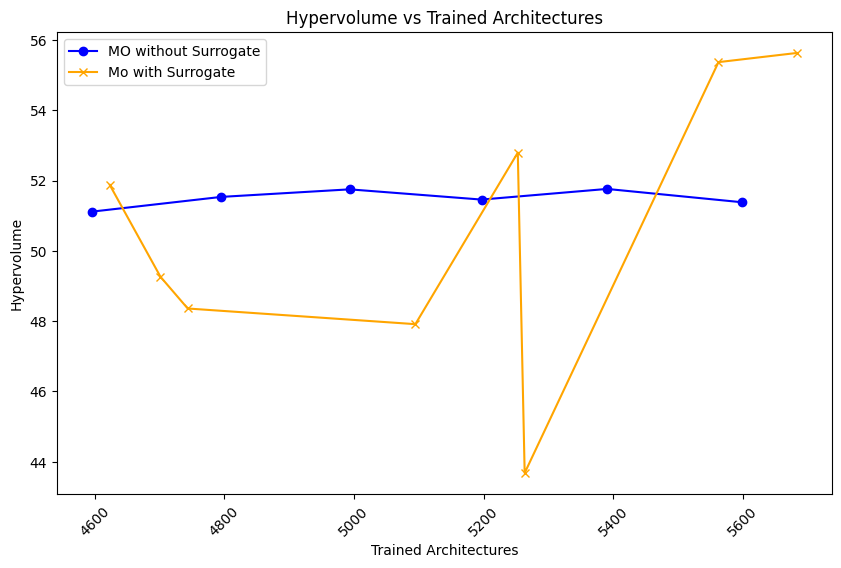

In [39]:
surr_plot_data = {selected_surr_mo_data[key]: hypervolume_20[key] for key in [300,400,500,600,700,800,900,1000]}
raw_mo_plot_data = {selected_raw_mo_data[key]: raw_hypervolumes[key] for key in [20,21,22,23,24,25]}

comparison_plot(raw_mo_plot_data, surr_plot_data, "Trained Architectures", "Hypervolume", "Hypervolume vs Trained Architectures")

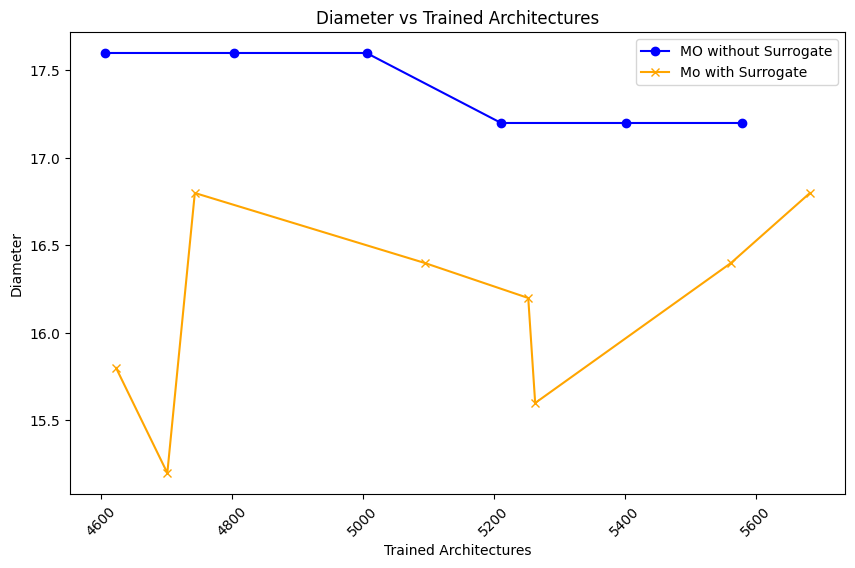

In [52]:
surr_plot_data = {selected_surr_mo_data[key]: diameter_20[key] for key in [300,400,500,600,700,800,900,1000]}
raw_mo_plot_data = {selected_raw_mo_data[key]: raw_diameters[key] for key in [20,21,22,23,24,25]}

comparison_plot(raw_mo_plot_data, surr_plot_data, "Trained Architectures", "Diameter", "Diameter vs Trained Architectures")

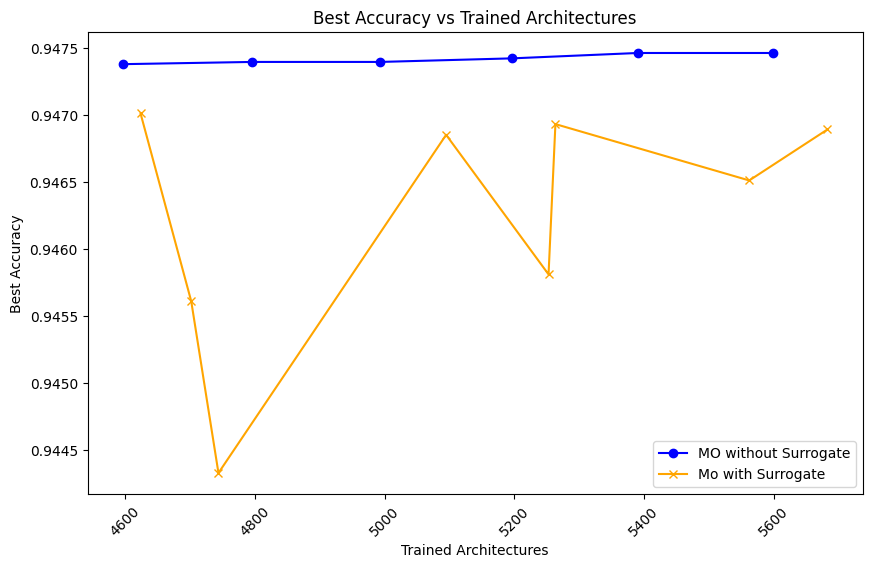

In [41]:
surr_plot_data = {selected_surr_mo_data[key]: best_acc_20[key] for key in [300,400,500,600,700,800,900,1000]}
raw_mo_plot_data = {selected_raw_mo_data[key]: raw_best_accs[key] for key in [20,21,22,23,24,25]}

comparison_plot(raw_mo_plot_data, surr_plot_data, "Trained Architectures", "Best Accuracy", "Best Accuracy vs Trained Architectures")

In [43]:
selected_surr_mo_data

{300: 4623.4,
 400: 5263.4,
 500: 4701.6,
 600: 5562.4,
 700: 4743.6,
 800: 5094.8,
 900: 5683.0,
 1000: 5252.8}

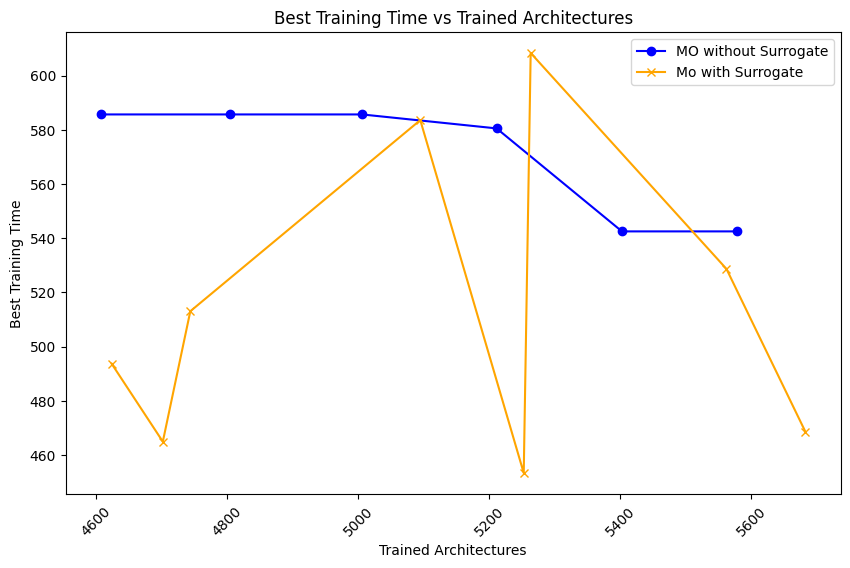

In [55]:
surr_plot_data = {selected_surr_mo_data[key]: best_train_time_20[key] for key in [300,400,500,600,700,800,900,1000]}
raw_mo_plot_data = {selected_raw_mo_data[key]: raw_best_train_times[key] for key in [20,21,22,23,24,25]}

comparison_plot(raw_mo_plot_data, surr_plot_data, "Trained Architectures", "Best Training Time", "Best Training Time vs Trained Architectures")

Seems like surrogate models definitely gives an advantage about choosing a train_time. However not for the accuracy. It might be possible that the on cifar10 dataset the accuracy is not changing much. It might be also related with the nature of xgb model. It might be possible that the xgb model is not able to learn the accuracy well. 

### MO Plots

In [70]:
small_data_sizes = [300, 400, 500, 600, 700, 800, 900, 1000]

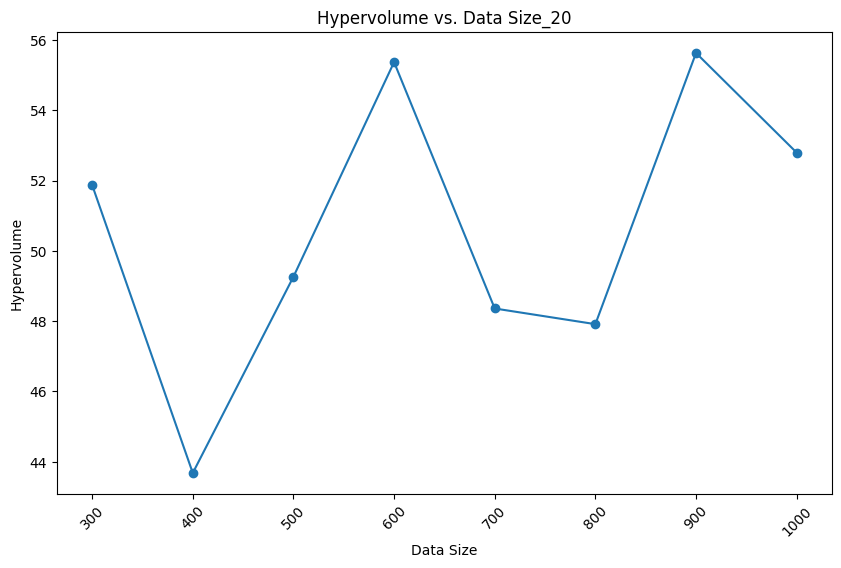

In [71]:
plot_results(hypervolume_20, "Hypervolume vs. Data Size_20", "Data Size", "Hypervolume", sizes=small_data_sizes)

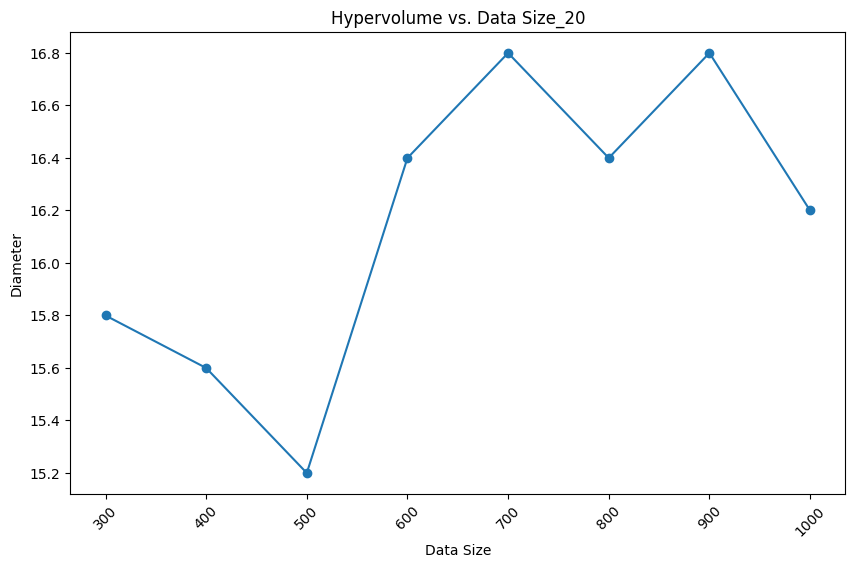

In [73]:
plot_results(diameter_20, "Diameter vs. Data Size_20", "Data Size", "Diameter", sizes=small_data_sizes)

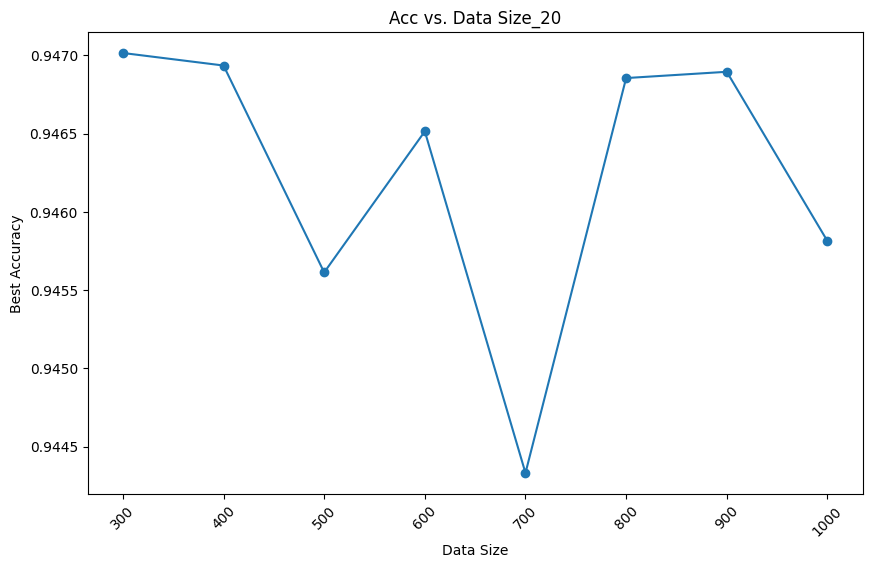

In [74]:
plot_results(best_acc_20, "Acc vs. Data Size_20", "Data Size", "Best Accuracy", sizes=small_data_sizes)

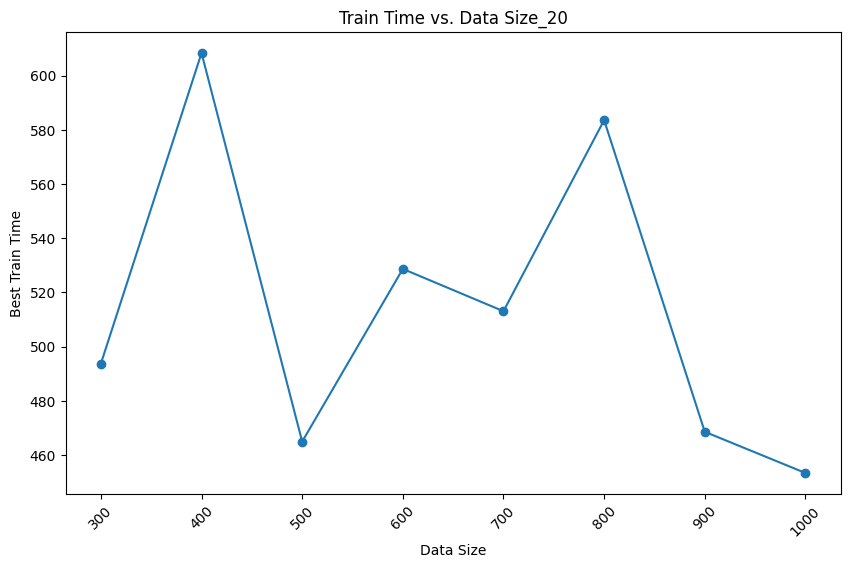

In [75]:
plot_results(best_train_time_20, "Train Time vs. Data Size_20", "Data Size", "Best Train Time", sizes=small_data_sizes)

In [76]:
big_data_sizes = [1000, 2000, 3000, 5000]

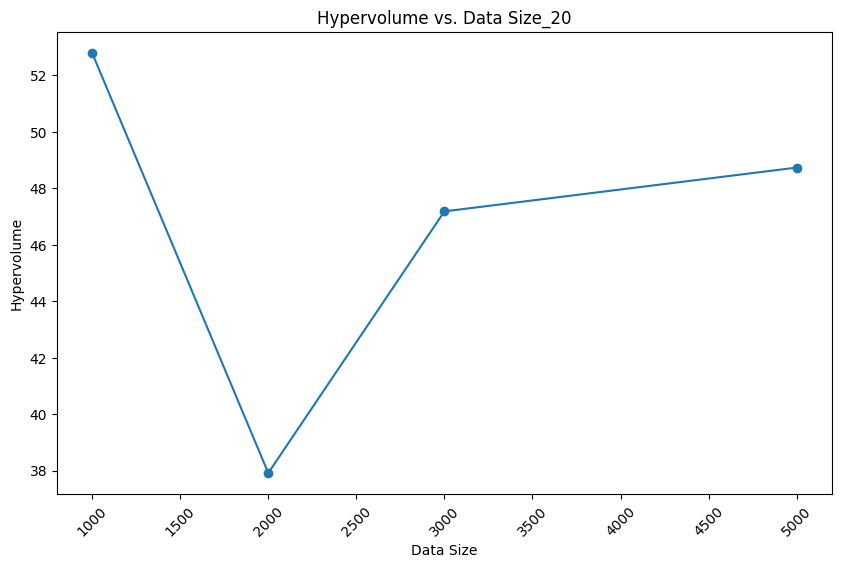

In [77]:
plot_results(hypervolume_20, "Hypervolume vs. Data Size_20", "Data Size", "Hypervolume", sizes=big_data_sizes)

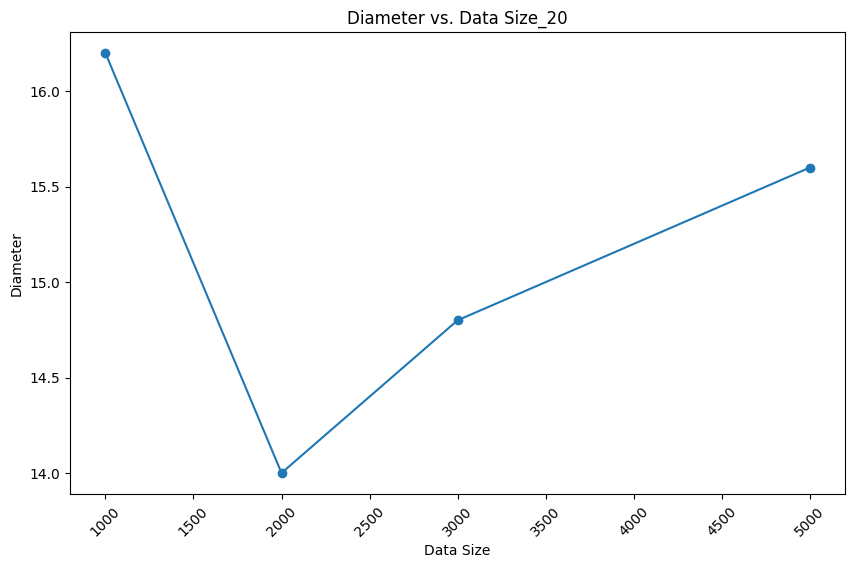

In [78]:
plot_results(diameter_20, "Diameter vs. Data Size_20", "Data Size", "Diameter", sizes=big_data_sizes)

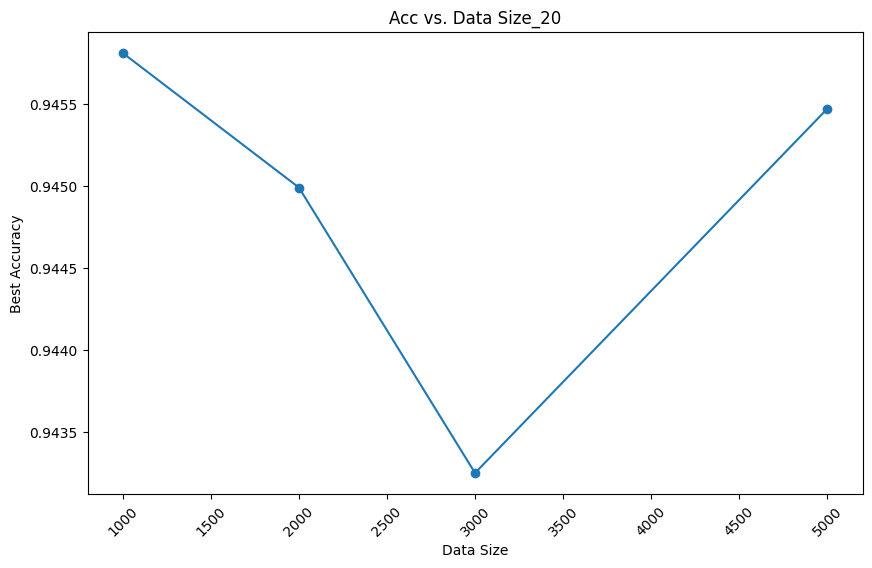

In [79]:
plot_results(best_acc_20, "Acc vs. Data Size_20", "Data Size", "Best Accuracy", sizes=big_data_sizes)

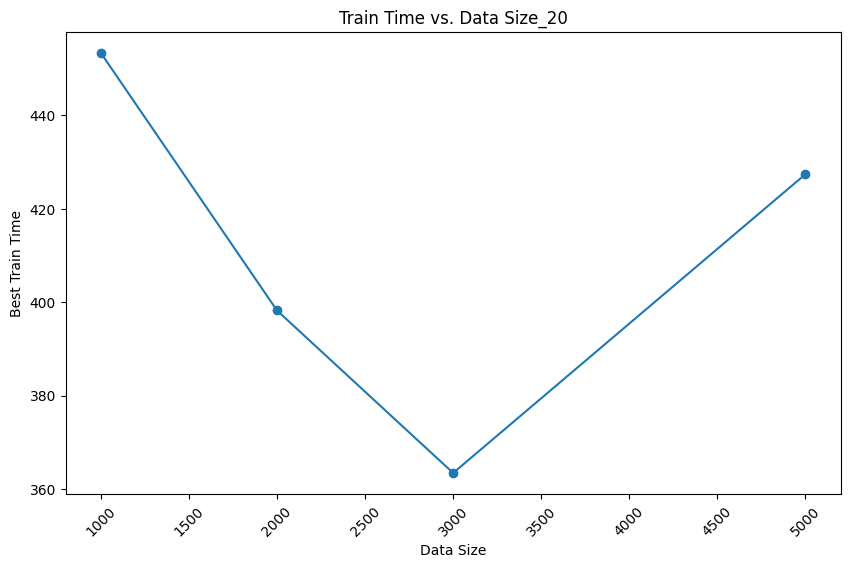

In [80]:
plot_results(best_train_time_20, "Train Time vs. Data Size_20", "Data Size", "Best Train Time", sizes=big_data_sizes)

## From Here I will be checking out the architecture sampling in NASLib

In [60]:
from naslib.utils import get_dataset_api


In [61]:

dataset_api = get_dataset_api("nasbench101", "cifar10")

Loading dataset from file... This may take a few minutes...
Loaded dataset in 5 seconds


In [62]:
np.random.seed(12)

In [64]:
raw_MO_archs = np.random.choice(list(dataset_api["nb101_data"].fixed_statistics.keys()), size=20, replace=False)
raw_MO_archs

array(['4af3ba72814c10217f903b265cce6789',
       '47637b49a0353abb644e22c7ecee2d91',
       '8c6323aac1a3879339302b947d9302f5',
       '88f148ae4255f2c9df8cc25651019eec',
       'd045bb96b4d694b09755bcb1884977f5',
       '948e8b8e8d0dd6cb0be2c9f9ff9df336',
       'e32bea15ad0d735febc2a30a7028c047',
       'd290812178865bd837fd6a6aa2d18a00',
       'f39807fc9f83a4f0829a5cfef88f2f56',
       'a7b4062409d529a37933af89dc6a943f',
       'aff1a91485ad40dfa2bea0b77065dd36',
       '85b75946301be12859f4c27fe75b90d5',
       'fcdc3fae4c3063b9019cc289f07a0194',
       'bbc19e3d7a4390499feeeb31128b428c',
       '2d510df2b953f2b3af40483d014744a2',
       '65454ca348463ffa3110d1dc8f6fb110',
       '102b5cb44738713d97a4415ba691a972',
       'f70fea106b2a0a54f2f6675a77ad97f7',
       '7f0aded1479224fb622fcd36fc44677a',
       '3d8b87268c093b099dc2bf8a1bdff6f5'], dtype='<U32')

In [65]:
np.random.seed(24)

In [66]:
raw_MO_archs_new = np.random.choice(list(dataset_api["nb101_data"].fixed_statistics.keys()), size=20, replace=False)
raw_MO_archs_new

array(['94273a4cb1f034caa13e65adca9a9086',
       '6287824a9cf425e9c2e1c0070bc0ada1',
       '0058a1f976554da12384cd682fe0959d',
       '7f72fb353d3d52010a16288494c2849f',
       '2eb97912fbcd01cfed4887baf69a72f9',
       '22aa9e05ee2a96e61056c0885510ef31',
       '8f9e2f49211ff8764dbda2f7c03932f5',
       '1eb337721b01d966f2ba08424d55a149',
       '5a95515f542bea83315e78fac2ae6856',
       'd3d0d71ddfb34ed468da7e11d01affeb',
       '12551fc9734ba14f564b1249b6ed2635',
       '24eb19e03deded464a1eb450f4e2c9d5',
       '36699a814e3e5fe7b11a8c82671e17aa',
       '82ce0d9d08e58534a852d00673edd331',
       'a11cda332c3e53ca8e5df11fa2ad1fc3',
       '78945c5b77c9c1c077bec30809f18cd2',
       'db891c6e1be306dfca1daef1c18aa8e3',
       '229ad37fca0db5be24bfcce9cb434885',
       'f220e298dfb2ee83f9b4a269f1f451b7',
       'e3bbfb3c79f524d4654c0ea0c4f346be'], dtype='<U32')

In [67]:
set(raw_MO_archs).intersection(set(raw_MO_archs_new))

set()